In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
#import s3fs
from herbie import Herbie
import numpy as np
import pandas as pd
import xarray as xr
import metpy
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from erftools.preprocessing import LambertConformalGrid, NativeHRRR
from erftools.preprocessing import hrrr_projection as hrrrproj

# Generate initial and boundary data from HRRR

In [3]:
#
# simulation params
#
start_date   = pd.to_datetime('2021-07-20 00:00')
end_date     = pd.to_datetime('2021-07-21 00:00')
prob_extent  = 320e3, 512e3, 10e3
n_cell       = 1280, 2048, 300

# COARSE GRID FOR TESTING
prob_extent  = 320e3, 500e3, 10e3
n_cell       = 128, 200, 200

# lambert conformal projection
cen_latlon   = 35.85, -123.72
std_parallel = 36.05
std_lon      = -65.0

# number of fringe points in wrfbdy
bdy_width = 5

dtype = np.float32

In [4]:
datadir = 'data'
suffix = '_COARSE'

os.makedirs(datadir, exist_ok=True)

## 1. Setup

In [5]:
# epoch times
start_time = (start_date - pd.to_datetime('1970-01-01')).total_seconds() 
stop_time = (end_date - pd.to_datetime('1970-01-01')).total_seconds() 
start_time, stop_time

(1626739200.0, 1626825600.0)

In [6]:
sim_time = end_date - start_date
onehr = pd.to_timedelta(1,'h')
num_hours = int(np.round(sim_time / onehr))
num_hours

24

In [7]:
datetimes = pd.date_range(start_date, end_date, freq='1h')
datetimes

DatetimeIndex(['2021-07-20 00:00:00', '2021-07-20 01:00:00',
               '2021-07-20 02:00:00', '2021-07-20 03:00:00',
               '2021-07-20 04:00:00', '2021-07-20 05:00:00',
               '2021-07-20 06:00:00', '2021-07-20 07:00:00',
               '2021-07-20 08:00:00', '2021-07-20 09:00:00',
               '2021-07-20 10:00:00', '2021-07-20 11:00:00',
               '2021-07-20 12:00:00', '2021-07-20 13:00:00',
               '2021-07-20 14:00:00', '2021-07-20 15:00:00',
               '2021-07-20 16:00:00', '2021-07-20 17:00:00',
               '2021-07-20 18:00:00', '2021-07-20 19:00:00',
               '2021-07-20 20:00:00', '2021-07-20 21:00:00',
               '2021-07-20 22:00:00', '2021-07-20 23:00:00',
               '2021-07-21 00:00:00'],
              dtype='datetime64[ns]', freq='H')

In [8]:
dx = [L/n for L,n in zip(prob_extent,n_cell)]
dx

[2500.0, 2500.0, 50.0]

In [9]:
# for reference
attrs = {
    'WEST-EAST_GRID_DIMENSION': n_cell[0]+1,
    'SOUTH-NORTH_GRID_DIMENSION': n_cell[1]+1,
    'DX': dx[0],
    'DY': dx[1],
    'SIMULATION_START_DATE': start_date.strftime('%Y-%m-%d_%H:%M:%S')
}
attrs

{'WEST-EAST_GRID_DIMENSION': 129,
 'SOUTH-NORTH_GRID_DIMENSION': 201,
 'DX': 2500.0,
 'DY': 2500.0,
 'SIMULATION_START_DATE': '2021-07-20_00:00:00'}

In [10]:
# setup computational grid
grid = LambertConformalGrid(
    ref_lat=cen_latlon[0],
    ref_lon=cen_latlon[1],
    truelat1=std_parallel,
    stand_lon=std_lon,
    dx=dx[0],
    dy=dx[0],
    nx=n_cell[0],
    ny=n_cell[1],
)

## 2. Get initial HRRR fields

In [11]:
hrrrdata = NativeHRRR(start_date)
#inv = hrrrdata.inventory()

✅ Found ┊ model=hrrr ┊ product=nat ┊ 2021-Jul-20 00:00 UTC F00 ┊ GRIB2 @ local ┊ IDX @ aws
🌉 Already have local copy --> /Users/equon/data/hrrr/20210720/hrrr.t00z.wrfnatf00.grib2


In [12]:
hrrrdata.set_output_grid(grid)

### check simulation domain

In [13]:
# grid corners from grid to HRRR projection
x_sw, y_sw = hrrrproj.transform_point(grid.x[ 0], grid.y[ 0], grid.proj)
x_se, y_se = hrrrproj.transform_point(grid.x[-1], grid.y[ 0], grid.proj)
x_ne, y_ne = hrrrproj.transform_point(grid.x[-1], grid.y[-1], grid.proj)
x_nw, y_nw = hrrrproj.transform_point(grid.x[ 0], grid.y[-1], grid.proj)

# get range of grid coords, in HRRR projected coordinates
hrrr_xg_min = np.min([x_sw, x_se, x_ne, x_nw])
hrrr_xg_max = np.max([x_sw, x_se, x_ne, x_nw])
hrrr_yg_min = np.min([y_sw, y_se, y_ne, y_nw])
hrrr_yg_max = np.max([y_sw, y_se, y_ne, y_nw])

# make sure our grid is inside
assert hrrr_xg_min > hrrrdata.xlim['sw']
assert hrrr_xg_max < hrrrdata.xlim['ne']
assert hrrr_yg_min > hrrrdata.ylim['sw']
assert hrrr_yg_max < hrrrdata.ylim['ne']

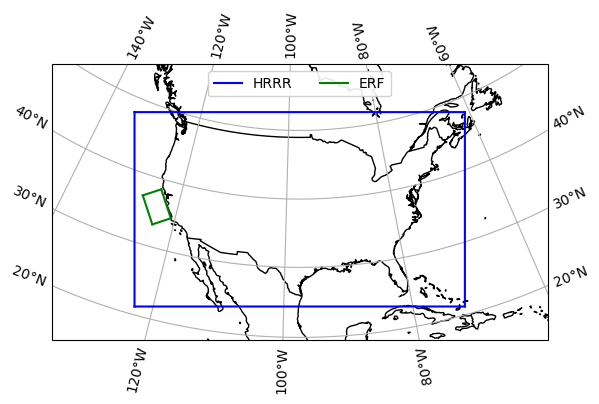

In [14]:
fig,ax = plt.subplots(subplot_kw=dict(projection=hrrrproj))
ax.set_extent([-135, -60, 19, 55], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle='-')
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

# HRRR
x1 = hrrrdata.x1
y1 = hrrrdata.y1
ax.plot(x1, y1[0 ]*np.ones_like(x1), 'b', transform=hrrrproj, label='HRRR')
ax.plot(x1, y1[-1]*np.ones_like(x1), 'b', transform=hrrrproj)
ax.plot(x1[0 ]*np.ones_like(y1), y1, 'b', transform=hrrrproj)
ax.plot(x1[-1]*np.ones_like(y1), y1, 'b', transform=hrrrproj)

# simulated grid
ax.plot(hrrrdata.xg[ :, 0], hrrrdata.yg[ :, 0], 'g', label='ERF')
ax.plot(hrrrdata.xg[ 0, :], hrrrdata.yg[ 0, :], 'g')
ax.plot(hrrrdata.xg[-1, :], hrrrdata.yg[-1, :], 'g')
ax.plot(hrrrdata.xg[ :,-1], hrrrdata.yg[ :,-1], 'g')

ax.legend(loc='upper center', ncol=2, framealpha=0.9)

## 3. Create initial condition data

In [15]:
hrrrdata.clip(hrrr_xg_min,hrrr_xg_max,
              hrrr_yg_min,hrrr_yg_max,
              inplace=True)

In [16]:
hrrrdata.calculate()

In [17]:
%%time
inp = hrrrdata.to_wrfinput(dtype=dtype)

# CPU times: user 14.6 s, sys: 14.5 s, total: 29.1 s
# Wall time: 33.8 s

Calculating unstaggered lat-lon
Calculating lat-lon staggered in x
Calculating lat-lon staggered in y
CPU times: user 189 ms, sys: 48.8 ms, total: 238 ms
Wall time: 244 ms


### Write out initial data

In [18]:
# add attributes for reference
for key,val in attrs.items():
    if key in inp.attrs:
        print('Overwriting',key,'=',inp.attrs[key],'with',val)
    inp.attrs[key] = val

In [19]:
%time inp.to_netcdf(f'{datadir}/wrfinput_d01{suffix}')

# CPU times: user 10.4 s, sys: 15.6 s, total: 26 s
# Wall time: 29.3 s

CPU times: user 131 ms, sys: 61.4 ms, total: 192 ms
Wall time: 691 ms


## 6. Interpolate to boundaries over time
From `IO/ERF_ReadFromWRFBdy.cpp`, need:
* `U`
* `V`
* ~~`R` (rho)~~ calculated in `convert_wrfbdy_data`
* `T`, moist perturbation temperature
* `QVAPOR`
* `MU`, perturbation dry air mass in column (Pa)
* ~~`PC`, perturbation column pressure (Pa)~~

at `BXS` (west), `BXE` (east), `BYS` (south), and `BYE` (north) locations. `MU` and `PC` do not vary in the vertical.

In [20]:
from gribapi.errors import GribInternalError
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [21]:
H = Herbie('2021-07-20 01:00:00',product='nat')
gh = H.xarray(f':HGT:\d+ hybrid')

✅ Found ┊ model=hrrr ┊ product=nat ┊ 2021-Jul-20 01:00 UTC F00 ┊ GRIB2 @ local ┊ IDX @ aws


In [22]:
%%time
bdylist = []
for itime,datetime in enumerate(datetimes):
    print(f'Generating boundary data at {datetime} (Time={itime})')
    
    if datetime==start_date:
        snapshot = hrrrdata
    else:
        snapshot = NativeHRRR(datetime)            
        print('- calculating field quantities')
        snapshot.clip(hrrr_xg_min,hrrr_xg_max,
                      hrrr_yg_min,hrrr_yg_max,
                      inplace=True)
        snapshot.calculate()            
        snapshot.set_output_grid(grid)
    
    print('- creating wrfbdy snapshot')
    bdy = snapshot.to_wrfbdy(bdy_width, dtype=dtype)
    bdylist.append(bdy)

# CPU times: user 5min 11s, sys: 1min 1s, total: 6min 13s
# Wall time: 6min 20s

Generating boundary data at 2021-07-20 00:00:00 (Time=0)
- creating wrfbdy snapshot
Generating boundary data at 2021-07-20 01:00:00 (Time=1)
✅ Found ┊ model=hrrr ┊ product=nat ┊ 2021-Jul-20 01:00 UTC F00 ┊ GRIB2 @ local ┊ IDX @ aws
🌉 Already have local copy --> /Users/equon/data/hrrr/20210720/hrrr.t01z.wrfnatf00.grib2
- calculating field quantities
- creating wrfbdy snapshot
Generating boundary data at 2021-07-20 02:00:00 (Time=2)
✅ Found ┊ model=hrrr ┊ product=nat ┊ 2021-Jul-20 02:00 UTC F00 ┊ GRIB2 @ local ┊ IDX @ aws
🌉 Already have local copy --> /Users/equon/data/hrrr/20210720/hrrr.t02z.wrfnatf00.grib2
- calculating field quantities
- creating wrfbdy snapshot
Generating boundary data at 2021-07-20 03:00:00 (Time=3)
✅ Found ┊ model=hrrr ┊ product=nat ┊ 2021-Jul-20 03:00 UTC F00 ┊ GRIB2 @ local ┊ IDX @ aws
🌉 Already have local copy --> /Users/equon/data/hrrr/20210720/hrrr.t03z.wrfnatf00.grib2
- calculating field quantities
- creating wrfbdy snapshot
Generating boundary data at 2021-0

In [23]:
bdy = xr.concat(bdylist, 'Time')

In [24]:
# add PC fields -- should not be needed
bdy['PC_BXS'] = 0.0 * bdy['MU_BXS']
bdy['PC_BXE'] = 0.0 * bdy['MU_BXE']
bdy['PC_BYS'] = 0.0 * bdy['MU_BYS']
bdy['PC_BYE'] = 0.0 * bdy['MU_BYE']

In [25]:
# cleanup
bdy = bdy.drop_vars(list(bdy.coords))

bdy.to_netcdf(f'{datadir}/wrfbdy_d01{suffix}')